In [4]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

## Generate Data for comparison with ISTDECO

In [ ]:
cfg = OmegaConf.load(f'../config/experiment/sim_2d_1.yaml')

crop_sz = 128
cfg.training.bs = 10
cfg.sim.random_crop.crop_sz = crop_sz
cfg.data_path.image_sim.image_shape = [1,16,1,crop_sz,crop_sz]
_, decode_dl = get_dataloader(cfg)
_, noise, micro = load_psf_noise_micro(cfg)

In [ ]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [ ]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'

densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
intensities = [1.]
# intensities = [0.8, 0.4, 0.2, 0.12]

In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *

gt_col = []
    
for d in densities:
    for i in intensities:

        k = f'dens_{d}_int_{i}'
        print(k)

        with h5py.File(out_dir+k+'.h5', 'w') as f:

            with torch.no_grad():

                ret_dict = next(iter(decode_dl))
                x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background']
                sim_vars = PointProcessUniform(local_rate[:,0]*0 + d, cfg.genm.intensity_dist.int_conc*i, cfg.genm.intensity_dist.int_rate, 
                                               cfg.genm.intensity_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(codebook), int_option=1).sample(from_code_book=True)
                ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1]))
                xsim = micro(*ch_inp)
                xsimn = micro.noise(xsim, background).sample()

                gt_vars = sim_vars[:-2]
                gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

            gt_df = px_to_nm(gt_df)
            gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

            add_df_to_hdf5(f, 'locations', gt_df)          
            f.create_dataset('frames', data=cpu(xsimn))

In [ ]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'
files = glob.glob(out_dir+'/*.h5')
base_str = 'bsub -gpu "num=1" -q gpu_rtx -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_sim_eval.py '

with open('run_slurm.sh', 'w') as f:
    for n in files:
        name = n.split('/')[-1]
        print(name)
        f.write(base_str + f'data_file={name}' + ' \n')

In [6]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'
intensities = [1]
files = glob.glob(out_dir+'sim_2d_1/*')

with h5py.File(files[0], 'a') as f:
    print(f.keys())

<KeysViewHDF5 ['high:0.2', 'istdeco', 'seed:0']>


In [18]:
mod_keys

['high:0.2', 'istdeco', 'seed:0']

In [110]:
densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
intensities = [1.0]

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())
mod_keys = ['high:0.2', 'istdeco']
    
jacs = {k:np.zeros([len(intensities), len(densities)]) for k in mod_keys}

for f in files:
    with h5py.File(f, 'r') as h:
        for m in mod_keys:

            k = f.split('/')[-1].split('.h5')[0] 
            d = k.split('_')[1]
            i = k.split('_')[3]

            perf = get_df_from_hdf5(h[m]['perf'])
            
            if float(i) in intensities:
                jacs[m][intensities.index(float(i)),densities.index(float(d))] = perf['jaccard'].values[0]
            
            if k == 'dens_0.1_int_1.0':
                print(m)
                display(perf)

high:0.2


,eff_3d,jaccard,n_matches,precision,recall,rmse_vol,rmse_x,rmse_y,rmse_z
0,88.438404,0.927453,13155,0.98201,0.943484,18.004499,11.883888,13.525353,0.0


istdeco


,eff_3d,jaccard,n_matches,precision,recall,rmse_vol,rmse_x,rmse_y,rmse_z
0,54.343206,0.730987,11736,0.847487,0.841713,73.779782,52.096975,52.243291,0.0


Text(0.5, 0, 'Density')

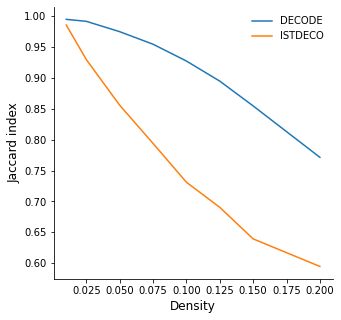

In [122]:
labels = {'high:0.2':'DECODE', 'istdeco':'ISTDECO'}

for i in range(len(intensities)):
    plt.figure(figsize=(5,5))
    for m in mod_keys:
        plt.plot(densities, jacs[m][i], label=labels[m])
    plt.legend(frameon=False)
    
sns.despine()
plt.ylabel('Jaccard index', size=12)
plt.xlabel('Density', size=12)

In [53]:
def sel_int_ch(res_df, codebook, sel_sig=True):
    
    if len(res_df):
    
        int_m = [f'int_{i}' for i in range(codebook.shape[1])]
        int_arr = res_df.loc[:,int_m].values
        int_arr_nz = int_arr[codebook[res_df['code_inds'].values].nonzero()].reshape([int_arr.shape[0], -1])
        ret_df = res_df.drop(columns=int_m)
        ret_df[int_m[:4]] = int_arr_nz
        ret_df['tot_int'] = int_arr_nz.sum(-1)
        ret_df['int_ratio'] = ((int_arr).sum(-1) - int_arr_nz.sum(-1)) / int_arr_nz.sum(-1)

        if sel_sig:
            int_s = [f'int_sig_{i}' for i in range(codebook.shape[1])]
            int_sig = res_df.loc[:,int_s].values
            int_sig_nz = int_sig[codebook[res_df['code_inds'].values].nonzero()].reshape([int_sig.shape[0], -1])
            ret_df = ret_df.drop(columns=int_s)
            ret_df[int_s[:4]] = int_sig_nz
            ret_df['tot_int_sig'] = int_sig_nz.sum(1)

        return ret_df
    
    else:
        
        return res_df

In [88]:
density = densities[3]
cfg = OmegaConf.load(f'../config/experiment/sim_2d_1.yaml')
codebook, targets = hydra.utils.instantiate(cfg.codebook)

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())
    
with h5py.File(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/dens_{density}_int_1.0.h5', 'r') as f:

    gt_df = get_df_from_hdf5(f['locations'])

for f in [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/sim_2d_1/dens_{density}_int_1.0.h5']:
    with h5py.File(f, 'r') as h:

        dec_df = get_df_from_hdf5(h['high:0.2']['locations'])
        ist_df = get_df_from_hdf5(h['istdeco']['locations_raw'])
        ist_df['loc_idx'] = np.arange(len(ist_df))
        
        perf, matches, _ = matching(gt_df, dec_df, tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False)
        dec_df.loc[:, 'class'] = 1
        dec_df.loc[dec_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        dec_df = sel_int_ch(dec_df, codebook)
        
        perf, matches, _ = matching(gt_df, ist_df, tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False)
        ist_df.loc[:, 'class'] = 1
        ist_df.loc[ist_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

Recall: 0.965
Precision: 0.989
Jaccard: 95.453
RMSE_vol: 11.458
Eff_3d: 92.686
FN: 369.0 FP: 111.0
Num. matches: 10077.000
Shift: 0.35,0.10,0.00
Recall: 0.978
Precision: 0.403
Jaccard: 39.964
RMSE_vol: 52.005
Eff_3d: 34.575
FN: 226.0 FP: 15127.0
Num. matches: 10220.000
Shift: -0.05,0.31,0.00


In [67]:
perf, matches, _ = matching(dec_df, ist_df.nlargest(3500,'quality'), tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False, ignore_z=True)

Recall: 0.318
Precision: 0.924
Jaccard: 30.948
RMSE_vol: 69.387
Eff_3d: 22.723
FN: 6953.0 FP: 265.0
Num. matches: 3235.000
Shift: -0.42,1.07,0.00


Text(0, 0.5, 'N Blanks')

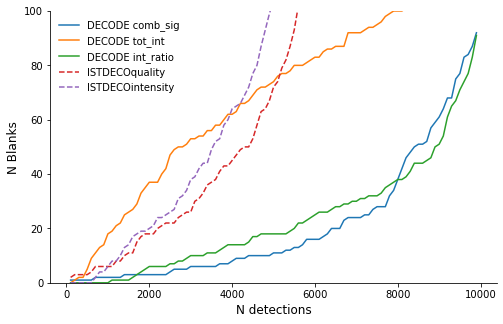

In [108]:
plt.figure(figsize=(8,5))
import seaborn as sns
for k in ['comb_sig','tot_int','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(dec_df, k, n_max=10000, ascending=b)
    plt.plot(r[0],r[1], label='DECODE '+k)

tra = ist_df[ist_df['intensity'] > 7000]
for k in ['quality','intensity']:
    r  = make_roc(tra, k, n_max=10000, ascending=False)
    plt.plot(r[0],r[1], label='ISTDECO' + k, linestyle='--')
    
plt.legend(frameon=False, fontsize=10)
plt.ylim(0,100)
sns.despine()

plt.xlabel('N detections', size=12)
plt.ylabel('N Blanks', size=12)